# 模型介绍

模型更加深了,并且加入了inception块:


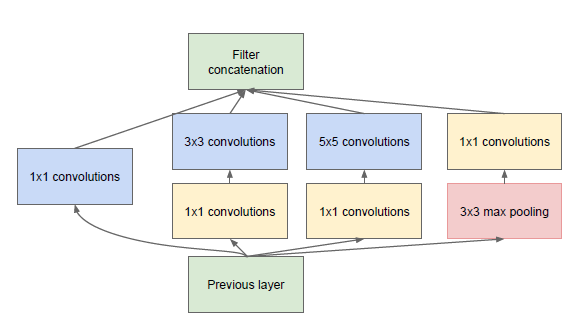


1. inception分两部分看,一部分是米黄色的1*1卷积,一部分是浅蓝色的1*1~5*5的卷积和红色的池化.

Part1:浅蓝色卷积+红色池化

怎么理解这里?

其实可以这么理解. 我们不知道模型需要通过怎样大小的卷积核来提取特征,因此就把4个选择给他,让他自己来选.

Part2:1*1 卷积

网上都说1*1卷积是用来降维的,是的,它是用来降depth的维度的. 比如输入是5*5*3的图像,经过它,可以实现5*5*2的图像.

可以理解为它对把不同depth的图像进行线性组合,线性组合的个数就是最终输出的depth个数.

# 搭建模型

In [15]:
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Input,Dense,Flatten,Dropout
from keras.layers import BatchNormalization,concatenate
from keras.layers import AveragePooling2D

In [16]:
# 普通层，就是加了一点batchnormalization
def conv_norm(pre_layer,filters,kernel,padding='same',strides=(1,1)):
    conv = Conv2D(kernel_size=kernel,filters=filters,strides=strides,padding=padding)(pre_layer)
    
    norm = BatchNormalization(axis=3)(conv)
    
    return norm

In [17]:
def inception(pre_layer,filters):
    branchx1=conv_norm(pre_layer,filters,(1,1),padding='same',strides=(1,1))
    
    branchx3=conv_norm(pre_layer,filters,(1,1),padding='same',strides=(1,1))
    branchx3=conv_norm(branchx3,filters,(3,3),padding='same',strides=(1,1))
    
    branchx5=conv_norm(pre_layer,filters,(1,1),padding='same',strides=(1,1))
    branchx5=conv_norm(branchx5,filters,(5,5),padding='same',strides=(1,1))
    
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(pre_layer)
    branchpool = conv_norm(branchpool,filters,(1,1),padding='same',strides=(1,1))
    
    x = concatenate([branchx1,branchx3,branchx5,branchpool],axis=3)
    
    return x

In [20]:
inputs = Input(shape=(224,224,3))

# 层1
x = conv_norm(inputs,64,(7,7),strides=(2,2),padding='same')
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

# 层2
x = conv_norm(inputs,192,(3,3),strides=(1,1),padding='same')
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

# 层3
x = inception(x,64)

# 层4
x = inception(x,120)

x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)  
x = inception(x,128)#512  
x = inception(x,128)  
x = inception(x,128)  
x = inception(x,132)#528  
x = inception(x,208)#832  
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)  
x = inception(x,208)  
x = inception(x,256)#1024  
x = AveragePooling2D(pool_size=(7,7),strides=(7,7),padding='same')(x)  
x = Dropout(0.4)(x)  
x = Dense(1000,activation='relu')(x)  
x = Dense(1000,activation='softmax')(x)  

model=Model(inputs=inputs,outputs=x)

model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])  

batch_input_shape: (None, 224, 224, 3)


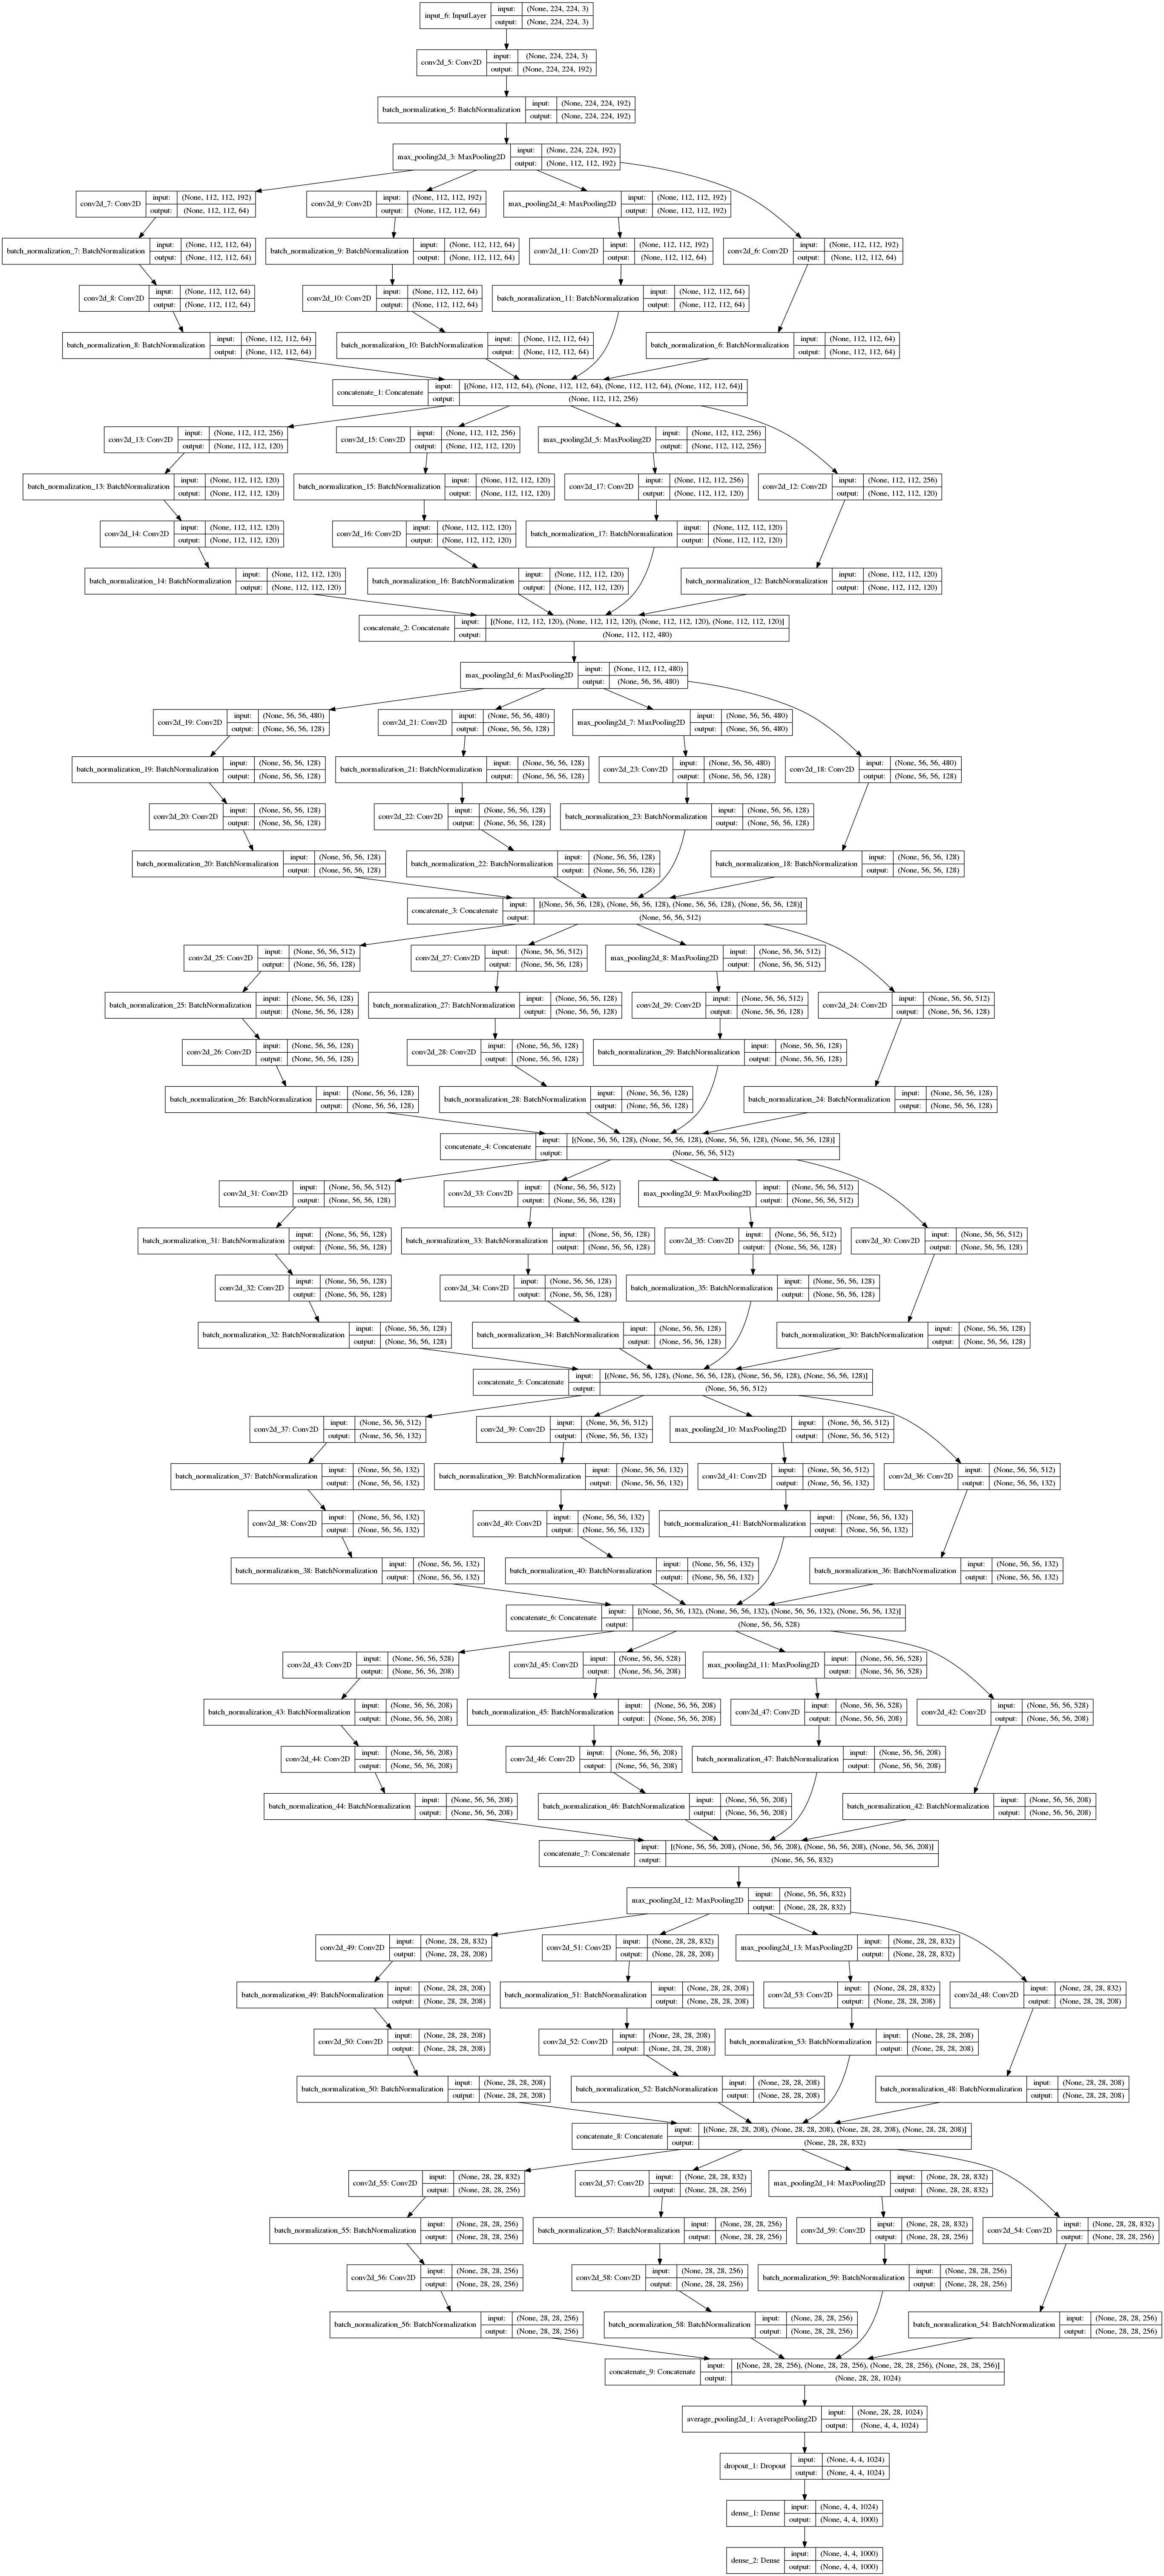

In [19]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')